In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
COLORS = ["#348ABD", "#A60628", "#7A68A6", "#467821", "#D55E00", "#CC79A7", "#56B4E9", "#009E73", "#F0E442", "#0072B2"]
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=COLORS) 

### Loading an Image

In [2]:
# Reading image
path_loc = "cifar-10-batches-py"
data = pickle.load(open(path_loc + "/data_batch_1", 'rb'), encoding='latin1')

index = np.random.randint(0, 10000)
image = data["data"][index]
image = np.reshape(image, (3, 32, 32)).transpose(1, 2, 0)

# Converting image to 0-1 scale
image = image / 255

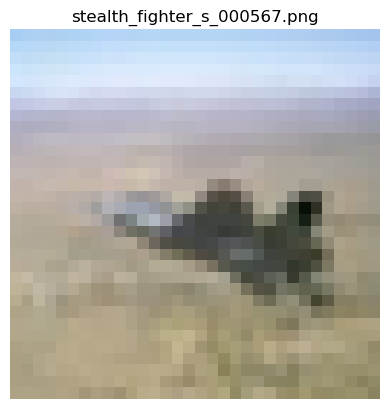

In [3]:
plt.imshow(image)
plt.axis('off')
plt.title(data["filenames"][index])
plt.show()

### Activation Functions

In [4]:
def parametericReLU(x):
    return x*(x>0) + 0.1*x*(x<=0)

In [5]:
def tanh(x):
    return np.tanh(x)

In [6]:
def ReLU(x):
    return np.maximum(0, x)

In [7]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [8]:
def softmax(x):
    return np.exp(x)/np.sum(np.exp(x), axis=1, keepdims=True)

### Pooling Functions

In [9]:
def maxPooling(x):
    return np.max(x)

def meanPooling(x):
    return np.mean(x)

### Convolution Function

In [10]:
def convolution(image, kernel, stride, padding, non_linearityFn):
    """
    Convolution function

    Parameters
    ----------
    image : numpy.ndarray shape (C, H, W)
        An input image
    kernel : numpy.ndarray shape (C, H, W)
        An input kernel
    stride : tuple
        Stride values (row_stride, col_stride)
    padding : int
        Padding value
    non_linearityFn : function
        Activation function
    
    Returns
    -------
    output : numpy.ndarray (H', W')
        Output image
    """    

    num_channels, image_rows, image_cols = image.shape
    _, kernel_rows, kernel_cols = kernel.shape
    row_stride, col_stride = stride

    # Padding the image
    padded_image = np.zeros((num_channels,image_rows + 2*padding, image_cols + 2*padding)) # Padding with zeros
    padded_image[:, padding:padded_image.shape[1]-padding, padding:padded_image.shape[2]-padding] = image  

    # Convolution output
    output_rows = np.floor((image_rows + 2*padding - kernel_rows)/row_stride + 1).astype(int)
    output_cols = np.floor((image_cols + 2*padding - kernel_cols)/col_stride + 1).astype(int)

    output = np.zeros((output_rows, output_cols))

    # Convolution
    for row in range(output_rows):
        for col in range(output_cols):
            output[row][col] = np.sum(padded_image[:, row*row_stride:row*row_stride + kernel_rows, col*col_stride:col*col_stride + kernel_cols]*kernel)
    
    # Activation function
    output = non_linearityFn(output)

    return output

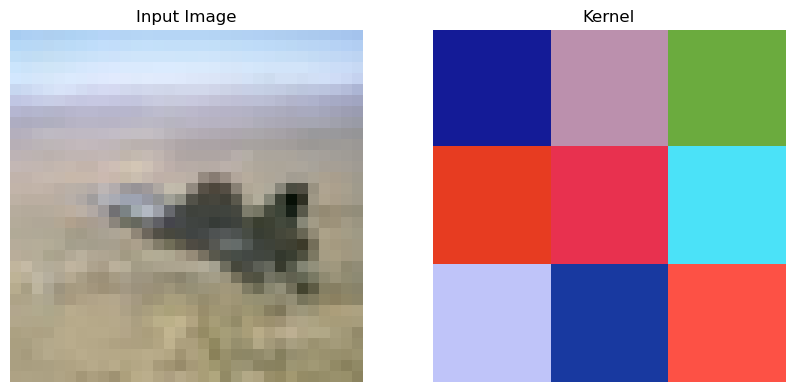

In [11]:
kernel = np.random.randn(3, 3, 3) # 3x3x3 kernel
stride = (1, 1)
padding = 0

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow((image * 255).astype(np.uint8))
plt.axis('off')
plt.title("Input Image")

plt.subplot(1, 2, 2)
plt.imshow((kernel * 255).astype(np.uint8))
plt.axis('off')
plt.title("Kernel")

plt.show()

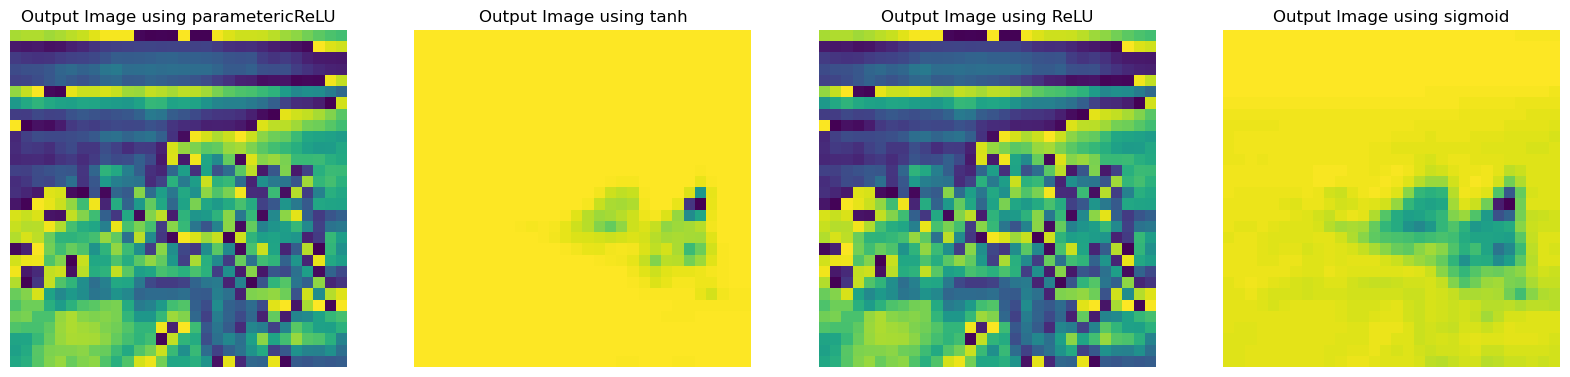

In [12]:
activation_functions = [parametericReLU, tanh, ReLU, sigmoid]
plt.figure(figsize=(5*len(activation_functions), 5))

for idx, activation_function in enumerate(activation_functions):
    # Transposing image and kernel to match the shape of convolution function
    output = convolution(image.transpose(2, 0, 1), kernel.transpose(2, 0, 1), stride, padding, activation_function)    
    
    plt.subplot(1, len(activation_functions), idx + 1)
    plt.imshow((output * 255).astype(np.uint8))
    plt.axis('off')
    plt.title("Output Image using " + activation_function.__name__)

plt.show()

### Pooling Function

In [13]:
def pooling(image, kernel_size, poolingFn, stride):
    """
    Pooling function

    Parameters
    ----------
    image : numpy.ndarray shape (C, H, W)
        Input image
    kernel_size : tuple
        Kernel size (kernel_rows, kernel_cols)
    poolingFn : function
        Pooling function
    stride : tuple
        Stride values (row_stride, col_stride)
    
    Returns
    -------
    output : numpy.ndarray (C, H', W')
        Output image
    """
    
    num_channels, image_rows, image_cols = image.shape
    kernel_rows, kernel_cols = kernel_size
    row_stride, col_stride = stride

    # Pooling output
    output_rows = np.floor((image_rows - kernel_rows)/row_stride + 1).astype(int) # 2 is the pooling window size and no padding done
    output_cols = np.floor((image_cols - kernel_cols)/col_stride + 1).astype(int) 

    output = np.zeros((num_channels, output_rows, output_cols))

    # Pooling
    for row in range(output_rows):
        for col in range(output_cols):
            for channel in range(num_channels):
                output[channel, row, col] = poolingFn(image[channel, row*row_stride:row*row_stride + kernel_rows, col*col_stride:col*col_stride + kernel_cols])

    return output

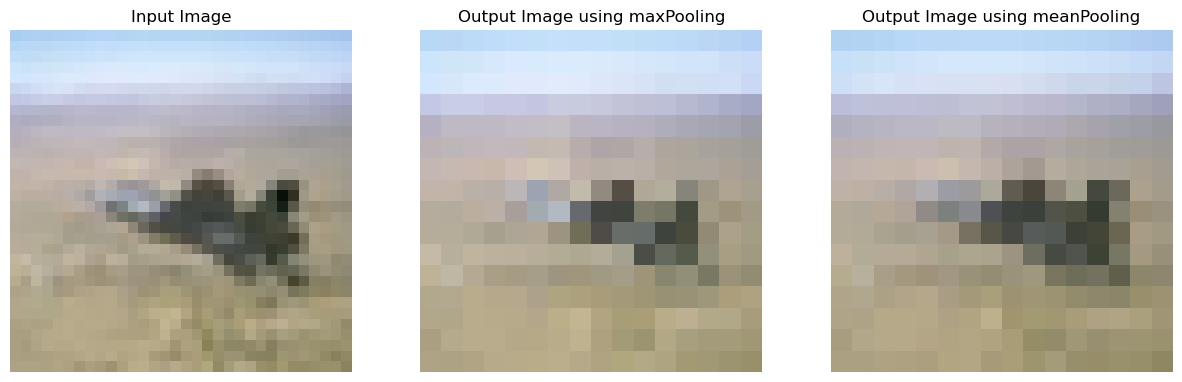

In [14]:
pooling_functions = [maxPooling, meanPooling]
plt.figure(figsize=(5*len(pooling_functions) + 5, 5))

plt.subplot(1, len(pooling_functions) + 1, 1)
plt.imshow(image)
plt.axis('off')
plt.title("Input Image")

for idx, pooling_function in enumerate(pooling_functions):
    output = pooling(image.transpose(2, 0, 1), (2, 2), pooling_function, (2, 2))    
    plt.subplot(1, len(pooling_functions) + 1, idx + 2)
    plt.imshow((output.transpose(1, 2, 0)*255).astype(np.uint8))
    plt.axis('off')
    plt.title("Output Image using " + pooling_function.__name__)

plt.show()

### Convolution Layer Function

In [15]:
def convolutionLayer(images, kernels, stride, padding, non_linearityFn):
    """
    Convolution layer function

    Parameters
    ----------
    images : numpy.ndarray shape (N, C, H, W)
        Set of input images 
    kernels : numpy.ndarray shape (K, C, H, W)
        Set of input kernels
    stride : tuple
        Stride values (row_stride, col_stride)
    padding : int
        Padding value
    non_linearityFn : function
        Activation function
    
    Returns
    -------
    output : numpy.ndarray   (N, K, H', W')
        Set of output images
    """

    if len(images.shape) == 3:
        images = np.expand_dims(images, axis=0)
    if len(kernels.shape) == 3:
        kernels = np.expand_dims(kernels, axis=0)

    num_images, _, image_rows, image_cols = images.shape
    num_kernels, _, kernel_rows, kernel_cols = kernels.shape

    # Convolution output
    output_rows = np.floor((image_rows + 2*padding - kernel_rows)/stride[0] + 1).astype(int)
    output_cols = np.floor((image_cols + 2*padding - kernel_cols)/stride[1] + 1).astype(int)

    output = np.zeros((num_images, num_kernels, output_rows, output_cols))

    for i, image in enumerate(images):
        for j, kernel in enumerate(kernels):
            output[i][j] = convolution(image, kernel, stride, padding, non_linearityFn)

    return output

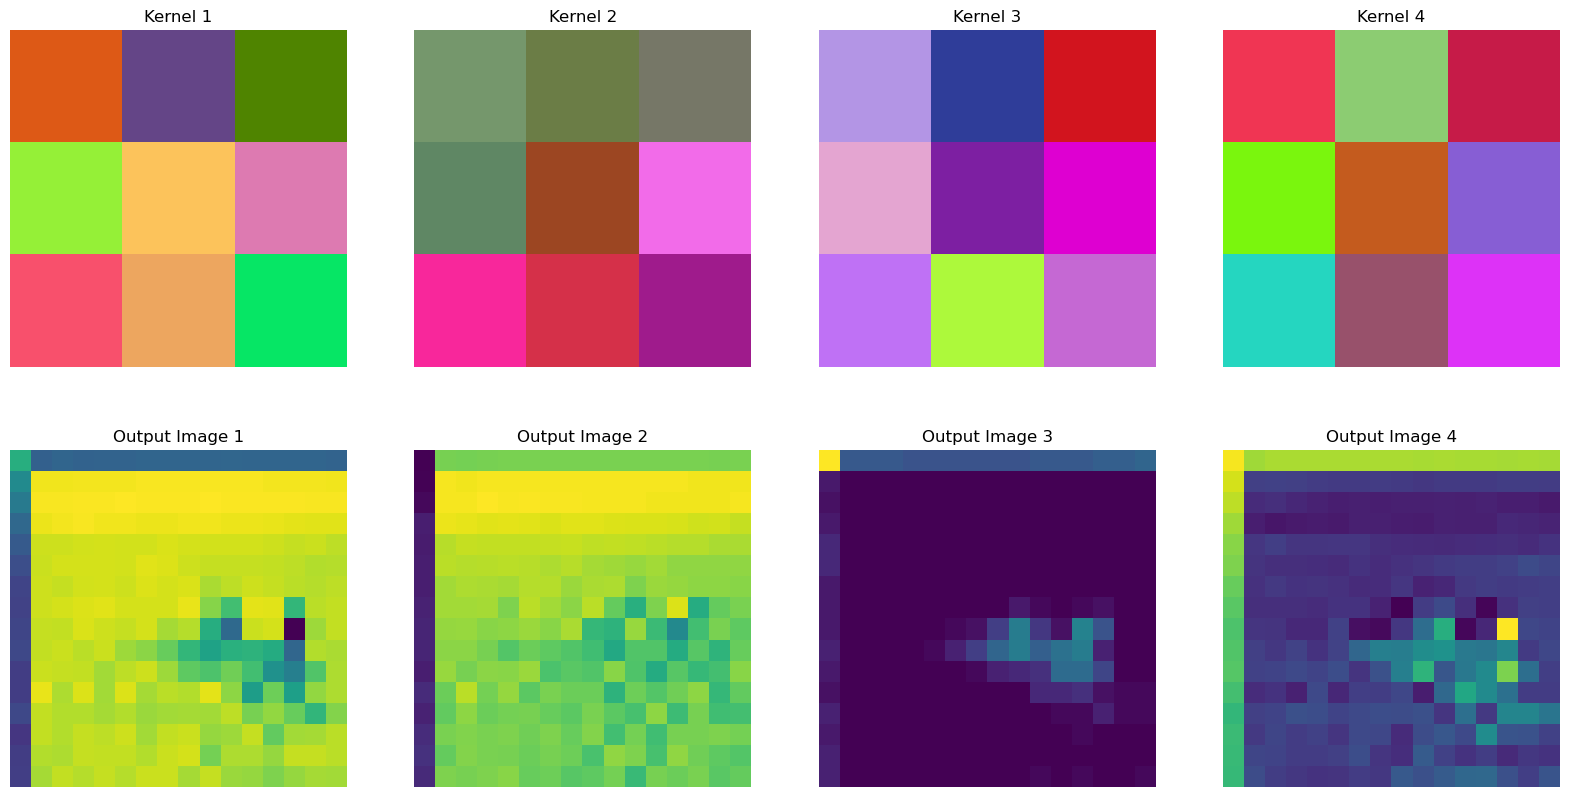

In [16]:
kernels = np.random.randn(4, 3, 3, 3) # 4x3x3x3 kernels
stride = (2, 2)
padding = 1

output = convolutionLayer(image.transpose(2, 0, 1), kernels.transpose(0, 2, 3, 1), stride, padding, sigmoid)
plt.figure(figsize=(5*output.shape[1], 5*2))

for idx in range(output.shape[1]):    
    plt.subplot(2, output.shape[1], idx + 1)
    plt.imshow((kernels[idx]*255).astype(np.uint8))
    plt.axis('off')
    plt.title("Kernel " + str(idx + 1))

    plt.subplot(2, output.shape[1], idx + 1 + output.shape[1])
    plt.imshow((output[0][idx] * 255).astype(np.uint8))
    plt.axis('off')
    plt.title("Output Image " + str(idx + 1))

plt.show()

### Pooling Layer Function

In [17]:
def poolingLayer(images, kernel_size, poolingFn, stride):
    """
    Pooling layer function

    Parameters
    ----------
    images : numpy.ndarray shape (N, C, H, W)
        Set of input images
    kernel_size : tuple
        Kernel size (kernel_rows, kernel_cols)
    poolingFn : function
        Pooling function
    stride : tuple
        Stride values (row_stride, col_stride)
    
    Returns
    -------
    output : numpy.ndarray   (N, C, H', W')
        Set of output images
    """

    if len(images.shape) == 3:
        images = images = np.expand_dims(images, axis=0)

    num_images, num_channels, image_rows, image_cols = images.shape

    # Pooling output
    output_rows = np.floor((image_rows - 2)/stride[0] + 1).astype(int) # 2 is the pooling window size and no padding done
    output_cols = np.floor((image_cols - 2)/stride[1] + 1).astype(int) 

    output = np.zeros((num_images, num_channels, output_rows, output_cols))

    for i, image in enumerate(images):
        output[i] = pooling(image, kernel_size, poolingFn, stride)

    return output

### Flattening Function

In [18]:
def flattenningFunction(images, output_dim):
    """
    Flattenning function

    Parameters
    ----------
    images : numpy.ndarray shape (N, C, H, W)
        Set of input images
    output_dim : int
        Output dimension
    
    Returns
    -------
    output : numpy.ndarray   (N, output_dim)
        Set of output images
    """

    weight_matrix = np.random.randn(images.shape[1]*images.shape[2]*images.shape[3], output_dim)
    return images.reshape(images.shape[0], -1) @ weight_matrix

### Multilayer Perceptron Function (Fully Connected)

In [19]:
def MLP(feature_vector, num_hidden_layers, size_hidden_layers, output_dim, non_linearityFn):

    """
    MLP function

    Parameters
    ----------
    feature_vector : numpy.ndarray shape (N, K)
        Set of input vectors
    num_hidden_layers : int
        Number of hidden layers
    size_hidden_layers : list
        Size of each hidden layers
    output_dim : int
        Output dimension
    non_linearityFn : function
        Activation function
    
    Returns
    -------
    score : numpy.ndarray   (N, output_dim)
        Set of output vectors
    probability : numpy.ndarray   (N, output_dim)
        Set of output vectors with softmax applied
    """

    size_hidden_layers = [feature_vector.shape[1]] + size_hidden_layers

    # Hidden layers
    for i in range(num_hidden_layers):
        weight_matrix = np.random.randn(size_hidden_layers[i], size_hidden_layers[i+1])
        bias_vector = np.random.randn(1, size_hidden_layers[i+1])
        feature_vector = non_linearityFn(feature_vector @ weight_matrix + bias_vector) 
    
    # Output layer
    weight_matrix = np.random.randn(feature_vector.shape[1], output_dim)
    score = feature_vector @ weight_matrix

    return score, softmax(score)

### Feed Forward Function

In [20]:
def feedForwardPath(images, flatten_output=False):
    """
    Feed forward path function

    Parameters
    ----------
    images : numpy.ndarray shape (N, C, H, W)
        Input image
    flatten_output : bool
        If True, returns the output of flattenning function
        
    Returns
    -------
    score : numpy.ndarray shape (N, K)
        Set of output vectors
    probability : numpy.ndarray shape (N, K)
        Set of output vectors with softmax applied
    """

    if len(images.shape) == 3:
        images = np.expand_dims(images, axis=0)

    # Convolution layer
    convolutionKernels = np.random.randn(16, 3, 3, 3)                                   # (K, C, H, W)
    convolutionOutput = convolutionLayer(images, convolutionKernels, (1, 1), 0, sigmoid) # (N, K, H, W)

    # Pooling layer
    poolingOutput = poolingLayer(convolutionOutput, (2,2), maxPooling, (2, 2)) # (N, C, H, W)

    # Convolution layer
    convolutionKernels = np.random.randn(8, poolingOutput.shape[1], 3, 3) # (K, C, H, W)
    convolutionOutput = convolutionLayer(poolingOutput, convolutionKernels, (1, 1), 0, sigmoid) # (N, K, H, W)

    # Pooling layer
    poolingOutput = poolingLayer(convolutionOutput, (2,2), maxPooling, (2, 2)) # (N, C, H, W)

    # Flattenning function
    flattenningOutput = flattenningFunction(poolingOutput, 32) # (N, K)

    if flatten_output == True:
        return flattenningOutput
    # MLP
    score, probability = MLP(flattenningOutput, 1, [16], 10, sigmoid) # (N, K)

    return score, probability

In [21]:
score, probability = feedForwardPath(image.transpose(2, 0, 1))
print("Input Shape: ", image.shape)
print("Score Shape: ", score.shape)
print("Probability Shape: ", probability.shape)

Input Shape:  (32, 32, 3)
Score Shape:  (1, 10)
Probability Shape:  (1, 10)


### Visualisation 

In [22]:
images, labels = [], []
for i in range(10):
    index = np.where(np.array(data["labels"]) == i)[0][0]
    image = data["data"][index]
    image = np.reshape(image, (3, 32, 32))
    image = image / 255
    images.append(image)
    labels.append(data["labels"][index])
images = np.stack(images, axis=0)

print("Images Shape: ", images.shape)
print("Number of images: ", images.shape[0])
print("Number of channels: ", images.shape[1])
print("Height of each image: ", images.shape[2])
print("Width of each image: ", images.shape[3])

Images Shape:  (10, 3, 32, 32)
Number of images:  10
Number of channels:  3
Height of each image:  32
Width of each image:  32


In [23]:
scores, probabilities = feedForwardPath(images)
print("Scores Shape: ", scores.shape)
print("Probabilities Shape: ", probabilities.shape)

Scores Shape:  (10, 10)
Probabilities Shape:  (10, 10)


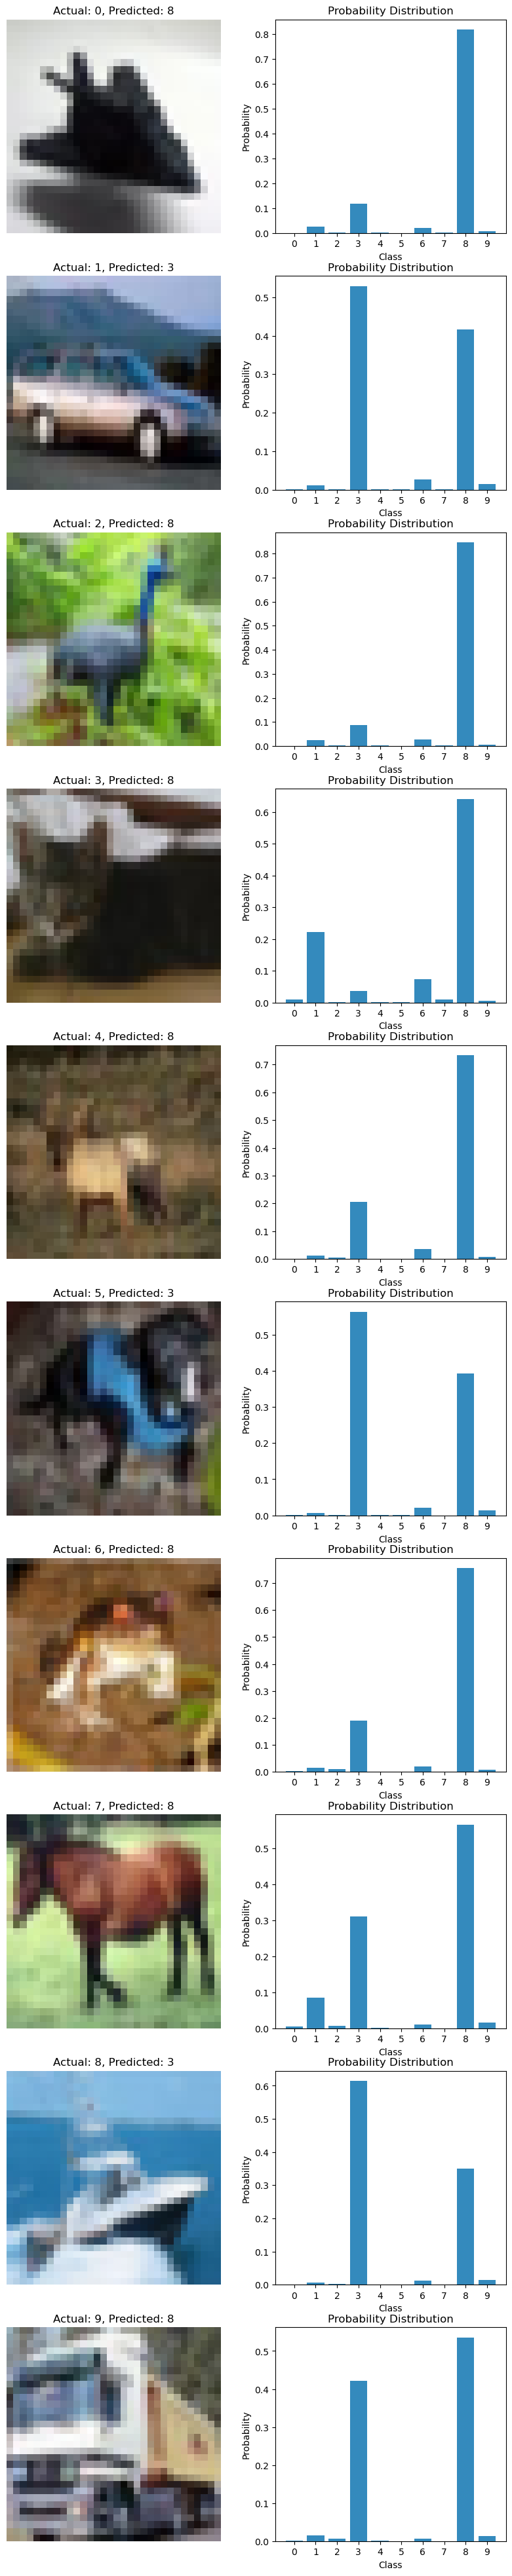

In [24]:
# Plotting image and corresponding probabilities
plt.figure(figsize=(10, 50))
for i, image in enumerate(images):
    plt.subplot(10, 2, 2*i + 1)
    plt.imshow(image.transpose(1, 2, 0)) # Transposing image into (H, W, C) format for plotting
    plt.axis('off')
    plt.title("Actual: " + str(labels[i]) + ", Predicted: " + str(np.argmax(probabilities[i])))

    plt.subplot(10, 2, 2*i + 2)
    plt.bar(np.arange(10), probabilities[i])
    plt.xticks(np.arange(10), np.arange(10))
    plt.ylabel("Probability")
    plt.xlabel("Class")
    plt.title("Probability Distribution")

plt.show()

In [25]:
# Get three image from each class
images, labels = [], []
for i in range(10):
    index = np.where(np.array(data["labels"]) == i)[0][:3]
    for idx in index:
        image = data["data"][idx]
        image = np.reshape(image, (3, 32, 32))
        image = image / 255
        images.append(image)
        labels.append(data["labels"][idx])
images = np.stack(images, axis=0)

In [26]:
embeddings = feedForwardPath(images, flatten_output=True)

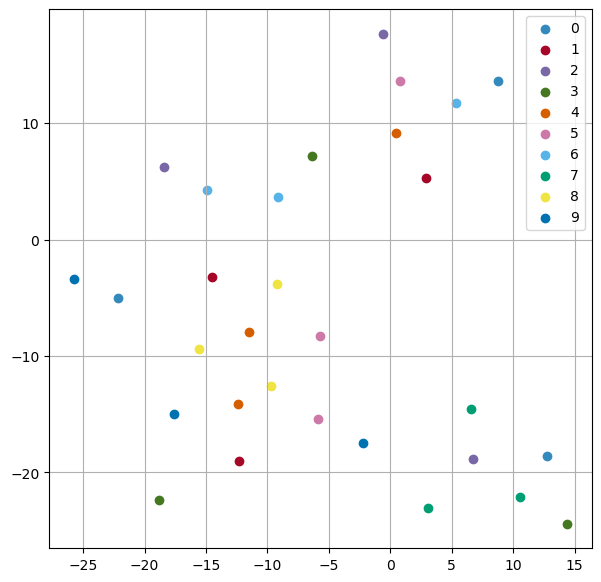

In [27]:
# Tsne plot of embeddings
from sklearn.manifold import TSNE
embeddings = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(embeddings) 

plt.figure(figsize=(7, 7))
for i in range(10):
    index = np.where(np.array(labels) == i)[0]
    plt.scatter(embeddings[index, 0], embeddings[index, 1], label=str(i))

plt.legend()
plt.grid(True)
plt.show()